In [2]:
RANDOM_STATE = 1

# Imports

In [1]:
import pandas as pd
import time
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',300)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

In [3]:
from nltk.corpus import stopwords
import re
import nltk
from nltk import tokenize
from nltk.stem import WordNetLemmatizer

In [13]:
import spacy

# Import datasets from drive

Note - for the purpose of brevity, data has already been preprocessed and cleaned.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import math

In [6]:
data_path = '/content/drive/MyDrive/BT4222/data/mbs_reviews.csv'
df = pd.read_csv(data_path)

In [29]:
def rating_clean(rating1, rating2):
  if not math.isnan(rating1):
    return rating1
  return rating2

In [30]:
df["rating"] = df.apply(lambda row: rating_clean(row['rating1'], row['rating2']), axis = 1)

In [31]:
def valid_rating(rating):
  if math.isnan(rating):
    return False
  return True

In [32]:
df['valid_rating'] = df.apply(lambda row: valid_rating(row['rating']), axis = 1)

In [33]:
def classify_rating(rating):
  if rating>=4:
    return "Positive"
  if rating<=2:
    return "Negative"
  return "Neutral"

In [34]:
df["label"] = df.apply(lambda row: classify_rating(row['rating']), axis = 1)

In [22]:
# preprocess function
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
spacy_lemmatizer = spacy.load('en_core_web_sm', disable=['parser','ner'])

def preprocess_text(title, review):


    text = str(title) + " " + str(review)
    # lower text
    text = text.lower()
    # Remove newline characters
    text = text.replace('\\n',' ').replace('\n', ' ').replace('\t', ' ').replace('\r', ' ').replace('\\', ' ')
    # Remove punctuation and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Remove multiple spaces
    text = re.sub(r'\s+',' ', text)
    # lemmatize
    text = spacy_lemmatizer(text)
    text = [token.lemma_ for token in text]
    # Remove stop words
    text = ' '.join([word for word in text if word not in stop_words])
    # tokenization done below, so no need to do it here.
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19371 entries, 0 to 19370
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date_of_stay                           18822 non-null  object 
 1   traveller_username                     19371 non-null  object 
 2   review_title                           19370 non-null  object 
 3   review_text                            19371 non-null  object 
 4   travel_type                            12198 non-null  object 
 5   traveller_country_origin               17237 non-null  object 
 6   traveller_total_contributions          19365 non-null  float64
 7   traveller_total_helpful_contributions  18055 non-null  float64
 8   rating1                                14743 non-null  float64
 9   rating2                                4627 non-null   float64
 10  rating                                 14743 non-null  float64
 11  va

In [35]:
df.head()

,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review
0,Date of stay: August 2023,Erica G,"Sick in Singapore, and MBS staff were amazing!","I was in Singapore on business and, unfortunately, I ended up having to stay in the room for several days because I got sick. As a result, I became very intimate and familiar with my room, moreso than I would've liked... Luckily, the room itself was very nice with a balcony and a very comfy be...",Trip type: Travelled on business,"Arlington Heights, Illinois",105.0,62.0,5.0,NaN,5.0,True,Positive,sick singapore mbs staff amazing I singapore business unfortunately I end stay room several day I get sick result I become intimate familiar room moreso I would like luckily room nice balcony comfy bed I spend ton time staff also amazing bring I anything everything I ask ton water bottle food kl...
1,Date of stay: April 2023,HJay,Lovely place to go whatever you plan to do!,"Whether it’s to soak up the Marina Bay cityscapes and the waterfront, shop the most expensive branded items Singapore has to offer, to visit art and science museum with young children, eat all the delicacies (at a marked up price) at Rasapura masters in B2 level Marina Bay Sands or to go up to t...",NaN,"Perth, Australia",14.0,11.0,NaN,NaN,NaN,False,Neutral,lovely place go whatever plan whether soak marina bay cityscape waterfront shop expensive brand item singapore offer visit art science museum young child eat delicacy mark price rasapura master b level marina bay sand go iconic marina bay sands hotel skydeck stunning view singapore must I take t...
2,Date of stay: September 2023,TaM,Thank you for the unforgettable memories,"I stayed at Marina Bay Sands to propose to my girlfriend. I started communicating with the staff about 3 weeks prior to our stay regarding the room decorations and bouquet preparations, and their quick response time made the process very smooth. To be honest, I was a bit nervous about preparing ...",Trip type: Travelled as a couple,NaN,1.0,NaN,5.0,NaN,5.0,True,Positive,thank unforgettable memory I stay marina bay sand propose girlfriend I start communicate staff week prior stay regard room decoration bouquet preparation quick response time make process smooth honest I bit nervous prepare proposal I go propose overseas english skill good support excellent I sta...
3,Date of stay: September 2023,Praxmeyer,Amazing hotel but not sure I’d do it again,We stayed one night in the hotel. The good parts of it are the staff are fantastic. Friendly and very willing to assist. The room was clean and spacious with an amazing view of the city. And of course the rooftop pool is simply amazing. However the room was missing glasses and a few other items ...,Trip type: Travelled as a couple,"Napier, New Zealand",444.0,232.0,4.0,NaN,4.0,True,Positive,amazing hotel sure I stay one night hotel good part staff fantastic friendly willing assist room clean spacious amazing view city course rooftop pool simply amazing however room miss glass item surprising bed also hard people would like I prefer soft bed overall great stay however I think I woul...
4,Date of stay: August 2023,TravelWriter74,Stunning hotel and overall an amazing experience,"We have just returned from a super couple of days at MBS. We travelled in from our 2 week holidays in Thailand and this 2 nighters at MBS was going to be a fab way to end our wondeful holiday and the hotel didn’t disappoint. From the lobby to the infinity pool, to the shopping mall to the restau...",Trip type: Travelled with family,"London, United Kingdom",166.0,114.0,NaN,5.0,5.0,True,Positive,stunning hotel overall amazing experience return super couple day mbs travel week holiday thailand nighter mbs go fab way end wondeful holiday hotel disappoint lobby infinity pool shopping mall restaurant hotel stunning fortunate enough give 

In [23]:
df["cleaned_review"] = df.apply(lambda row: preprocess_text(row['review_title'], row['review_text']), axis = 1)

In [82]:
df.to_csv("/content/drive/MyDrive/BT4222/data/cleaned_mbs_reviews.csv")

# Data Preprocessing

Then, we split the data into train and validation sets using train_test_split.

In [36]:
valid_df = df[df["valid_rating"]]
valid_df

,date_of_stay,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating1,rating2,rating,valid_rating,label,cleaned_review
0,Date of stay: August 2023,Erica G,"Sick in Singapore, and MBS staff were amazing!","I was in Singapore on business and, unfortunately, I ended up having to stay in the room for several days because I got sick. As a result, I became very intimate and familiar with my room, moreso than I would've liked... Luckily, the room itself was very nice with a balcony and a very comfy be...",Trip type: Travelled on business,"Arlington Heights, Illinois",105.0,62.0,5.0,NaN,5.0,True,Positive,sick singapore mbs staff amazing I singapore business unfortunately I end stay room several day I get sick result I become intimate familiar room moreso I would like luckily room nice balcony comfy bed I spend ton time staff also amazing bring I anything everything I ask ton water bottle food kl...
2,Date of stay: September 2023,TaM,Thank you for the unforgettable memories,"I stayed at Marina Bay Sands to propose to my girlfriend. I started communicating with the staff about 3 weeks prior to our stay regarding the room decorations and bouquet preparations, and their quick response time made the process very smooth. To be honest, I was a bit nervous about preparing ...",Trip type: Travelled as a couple,NaN,1.0,NaN,5.0,NaN,5.0,True,Positive,thank unforgettable memory I stay marina bay sand propose girlfriend I start communicate staff week prior stay regard room decoration bouquet preparation quick response time make process smooth honest I bit nervous prepare proposal I go propose overseas english skill good support excellent I sta...
3,Date of stay: September 2023,Praxmeyer,Amazing hotel but not sure I’d do it again,We stayed one night in the hotel. The good parts of it are the staff are fantastic. Friendly and very willing to assist. The room was clean and spacious with an amazing view of the city. And of course the rooftop pool is simply amazing. However the room was missing glasses and a few other items ...,Trip type: Travelled as a couple,"Napier, New Zealand",444.0,232.0,4.0,NaN,4.0,True,Positive,amazing hotel sure I stay one night hotel good part staff fantastic friendly willing assist room clean spacious amazing view city course rooftop pool simply amazing however room miss glass item surprising bed also hard people would like I prefer soft bed overall great stay however I think I woul...
4,Date of stay: August 2023,TravelWriter74,Stunning hotel and overall an amazing experience,"We have just returned from a super couple of days at MBS. We travelled in from our 2 week holidays in Thailand and this 2 nighters at MBS was going to be a fab way to end our wondeful holiday and the hotel didn’t disappoint. From the lobby to the infinity pool, to the shopping mall to the restau...",Trip type: Travelled with family,"London, United Kingdom",166.0,114.0,NaN,5.0,5.0,True,Positive,stunning hotel overall amazing experience return super couple day mbs travel week holiday thailand nighter mbs go fab way end wondeful holiday hotel disappoint lobby infinity pool shopping mall restaurant hotel stunning fortunate enough give two newly renovate room floor view incredible room fau...
5,Date of stay: September 2023,Ingo S,Perfect stay!,"One of the best hotels we stayed! Great environment, great service, great rooms and very kind personal. In addition we had luck to meet Dziauddin Mahamud, a concierge who helped us not only with a couple of brillant suggestions but with a total Kuala Lumpur itinerary. we only mentioned to stay t...",Trip type: Travelled as a couple,"Ilmenau, Germany",3.0,NaN,5.0,NaN,5.0,True,Positive,perfect stay one good hotel stay great environment great service great room kind personal addition luck meet dziauddin mahamud concierge help couple brillant suggestion total kuala lumpur itinerary mention stay day holiday bottom line reco

In [48]:
# Drop neutral
train_df = valid_df[valid_df["label"]!="Neutral"]

In [49]:
train_set, test_set = train_test_split(train_df[['cleaned_review','label']],
                                      test_size=0.2,
                                      shuffle=True,
                                      random_state=RANDOM_STATE)
X_train = train_set.cleaned_review
y_train = train_set.label
X_test = test_set.cleaned_review
y_test = test_set.label

In [50]:
y_train.value_counts()

Positive    12417
Negative     1324
Name: label, dtype: int64

The data is very imbalanced, so we will perform undersampling on the train data.

In [51]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train, y_train = rus.fit_resample(train_set, train_set['label'])
train_set = shuffle(X_train)
train_set.reset_index(inplace=True, drop=True)

In [52]:
X_train = train_set['cleaned_review']
y_train = train_set['label']

In [53]:
y_train.value_counts()

Negative    1324
Positive    1324
Name: label, dtype: int64

We can now use this data for training and testing. To use text data in our machine learning models, we first convert them into TF-IDF vectors.

In [54]:
vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,3))
tfidf_features_train = vectorizer.fit_transform(X_train)
tfidf_features_test = vectorizer.transform(X_test)

In [ ]:
# save the model to disk
filename = 'tfidf_vectorizer.sav'
pickle.dump(vectorizer, open(filename, 'wb'))

# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))

# Machine Learning Models

## Logistic Regression model

In [55]:
param_grid = {"C":np.logspace(-3,3,7),
              "penalty":["l1","l2"]
              }

lr_model = GridSearchCV(LogisticRegression(),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)

#lr_model = LogisticRegression(C=10.0,penalty='l2')
lr_model.fit(tfidf_features_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=5)

In [56]:
print('Best Parameters found : {}'.format(lr_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(lr_model.best_score_))

Best Parameters found : {'C': 1000.0, 'penalty': 'l2'}
Best Accuracy found : 0.922



Evaluation on test set

In [63]:
predictions = lr_model.predict(tfidf_features_test)
cm = confusion_matrix(y_test, predictions, labels=lr_model.classes_)

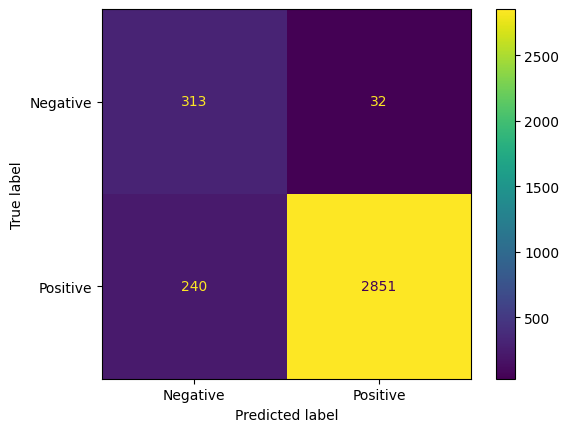

In [64]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot()
plt.show()

In [67]:

t1 = time.time()

predictions = lr_model.predict(tfidf_features_test)
t2 = time.time()
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test, predictions, labels=lr_model.classes_))

Time Taken 0.010976076126098633 s, 313044.4760518713 rows per s
              precision    recall  f1-score   support

    Negative       0.57      0.91      0.70       345
    Positive       0.99      0.92      0.95      3091

    accuracy                           0.92      3436
   macro avg       0.78      0.91      0.83      3436
weighted avg       0.95      0.92      0.93      3436

[[ 313   32]
 [ 240 2851]]


## Multinomial Naive Bayes Model

In [68]:
param_grid =  {'alpha':[0, 0.01, 0.1, 0.5, 1.0, 10.0],
               'fit_prior': [True, False],
               'class_prior': [None, [0.1,]*3]
              }

nb_model = GridSearchCV(MultinomialNB(),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)
#nb_model = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nb_model.fit(tfidf_features_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0, 0.01, 0.1, 0.5, 1.0, 10.0],
                         'class_prior': [None, [0.1, 0.1, 0.1]],
                         'fit_prior': [True, False]},
             verbose=5)

In [69]:
print('Best Parameters found : {}'.format(nb_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(nb_model.best_score_))

Best Parameters found : {'alpha': 0.5, 'class_prior': None, 'fit_prior': True}
Best Accuracy found : 0.930



Evaluation on test set

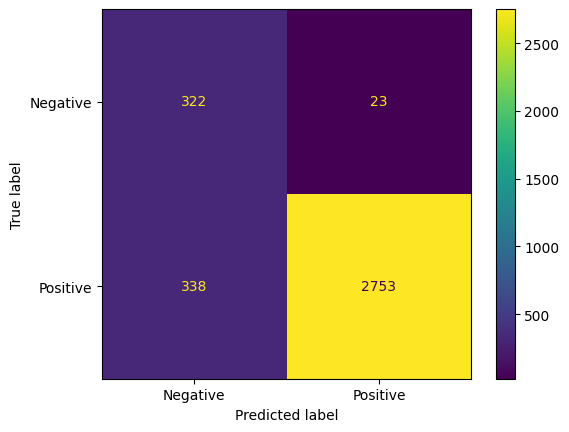

In [71]:
predictions = nb_model.predict(tfidf_features_test)
cm = confusion_matrix(y_test, predictions, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot()
plt.show()

In [72]:

t1 = time.time()

predictions = nb_model.predict(tfidf_features_test)
t2 = time.time()
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test, predictions, labels=nb_model.classes_))

Time Taken 0.03557610511779785 s, 96581.67999624708 rows per s
              precision    recall  f1-score   support

    Negative       0.49      0.93      0.64       345
    Positive       0.99      0.89      0.94      3091

    accuracy                           0.89      3436
   macro avg       0.74      0.91      0.79      3436
weighted avg       0.94      0.89      0.91      3436

[[ 322   23]
 [ 338 2753]]


## Linear SVM

In [73]:
param_grid =  {'C':[0, 0.01, 0.1, 0.5, 1.0, 10.0],
               'dual': [True, False],
               'penalty': ['l1','l2'],
              }

lsvm_model = GridSearchCV(sklearn.svm.LinearSVC(random_state=RANDOM_STATE),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)
#lsvm_model = sklearn.svm.LinearSVC(C=1.0,dual=False,penalty='l1')
lsvm_model.fit(tfidf_features_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=LinearSVC(random_state=1), n_jobs=-1,
             param_grid={'C': [0, 0.01, 0.1, 0.5, 1.0, 10.0],
                         'dual': [True, False], 'penalty': ['l1', 'l2']},
             verbose=5)

In [74]:
print('Best Parameters found : {}'.format(lsvm_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(lsvm_model.best_score_))

Best Parameters found : {'C': 10.0, 'dual': True, 'penalty': 'l2'}
Best Accuracy found : 0.925



Evaluation on test set

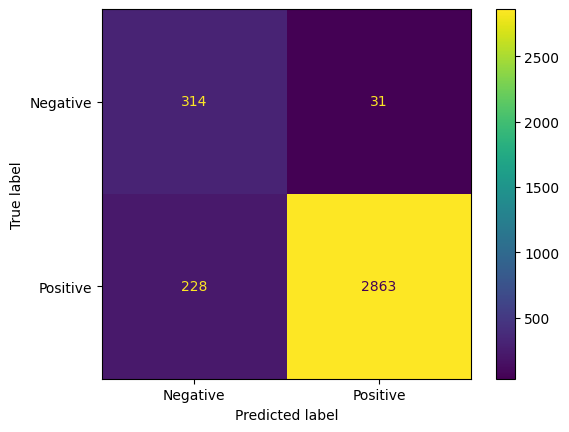

In [76]:
predictions = lsvm_model.predict(tfidf_features_test)
cm = confusion_matrix(y_test, predictions, labels=lsvm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lsvm_model.classes_)
disp.plot()
plt.show()

In [77]:
t1 = time.time()

predictions = lsvm_model.predict(tfidf_features_test)
t2 = time.time()
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test, predictions, labels=lsvm_model.classes_))

Time Taken 0.014520406723022461 s, 236632.49009080013 rows per s
              precision    recall  f1-score   support

    Negative       0.58      0.91      0.71       345
    Positive       0.99      0.93      0.96      3091

    accuracy                           0.92      3436
   macro avg       0.78      0.92      0.83      3436
weighted avg       0.95      0.92      0.93      3436

[[ 314   31]
 [ 228 2863]]


## Random Forest Classifier

In [78]:
param_grid = {'n_estimators': [100,200],
              'max_features': ['sqrt','log2'],
              'max_depth': [5,10,15],
}

rf_model = GridSearchCV(RandomForestClassifier(),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)
#rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=15)
rf_model.fit(tfidf_features_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200]},
             verbose=5)

In [79]:
print('Best Parameters found : {}'.format(rf_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(rf_model.best_score_))

Best Parameters found : {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}
Best Accuracy found : 0.860



Evaluate on test set

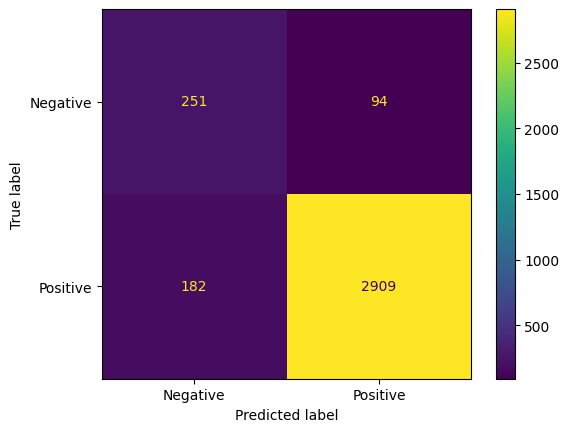

In [80]:
predictions = rf_model.predict(tfidf_features_test)
cm = confusion_matrix(y_test, predictions, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()

In [81]:
t1 = time.time()

predictions = rf_model.predict(tfidf_features_test)
t2 = time.time()
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test, predictions, labels=rf_model.classes_))

Time Taken 0.3414480686187744 s, 10063.023679997095 rows per s
              precision    recall  f1-score   support

    Negative       0.58      0.73      0.65       345
    Positive       0.97      0.94      0.95      3091

    accuracy                           0.92      3436
   macro avg       0.77      0.83      0.80      3436
weighted avg       0.93      0.92      0.92      3436

[[ 251   94]
 [ 182 2909]]
